# IMPORT

In [1]:
import torch
import torch.nn.functional as F
from torch.nn import BCEWithLogitsLoss, GRUCell
from torch_geometric.data import Data
from sklearn.metrics import roc_auc_score,average_precision_score

import random
import pandas as pd
from torch_geometric.utils import negative_sampling
import torch_geometric.transforms as T
from torch_geometric.utils import train_test_split_edges
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.nn import GCNConv,SAGEConv,GATv2Conv, GINConv, Linear

import torch
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

import copy
import itertools
import json

# LOAD DATASET

In [2]:
#'struct' for structural features 
#(pagerank, in and out degree, avg neighbor degree, avg clustering coeff)
#'text' for textual features from pre-trained multilingual SBERT
feature = 'text' 

In [3]:
snapshots = []
for i in range(4):
    snap = Data()
    snap.x = torch.load(f'steemit-hardfork-data/snapshot_{i}_x_{feature}.pt')
    snap.edge_index = torch.load(f'steemit-hardfork-data/snapshot_{i}_edge_index.pt')
    snapshots.append(snap)

In [4]:
snapshots

[Data(x=[77029, 384], edge_index=[2, 74306]),
 Data(x=[77029, 384], edge_index=[2, 69540]),
 Data(x=[77029, 384], edge_index=[2, 75241]),
 Data(x=[77029, 384], edge_index=[2, 82566])]

# LOAD MODEL

In [5]:
from tgn import ROLANDLP

In [6]:
def test(model, test_data, data, isnap, device='cpu'):
    model.eval()

    test_data = test_data.to(device)

    h, _ = model(test_data.x, test_data.edge_index, edge_label_index = test_data.edge_label_index, isnap=isnap)
    
    pred_cont_link = torch.sigmoid(h).cpu().detach().numpy()
    
    label_link = test_data.edge_label.cpu().detach().numpy()
      
    avgpr_score_link = average_precision_score(label_link, pred_cont_link)
    
    return avgpr_score_link

In [7]:
from sklearn.metrics import *

def train_single_snapshot(model, data, train_data, val_data, test_data, isnap,\
                          last_embeddings, optimizer, device='cpu', num_epochs=50, verbose=False):
    
    avgpr_val_max = 0
    best_model = model
    train_data = train_data.to(device)
    best_epoch = -1
    best_current_embeddings = []
    
    avgpr_trains = []
    #avgpr_vals = []
    avgpr_tests = []
    
    tol = 1
    
    for epoch in range(num_epochs):
        model.train()
        ## Note
        ## 1. Zero grad the optimizer
        ## 2. Compute loss and backpropagate
        ## 3. Update the model parameters
        optimizer.zero_grad()

        pred,\
        current_embeddings =\
            model(train_data.x, train_data.edge_index, edge_label_index = train_data.edge_label_index,\
                  isnap=isnap, previous_embeddings=last_embeddings)
        
        loss = model.loss(pred, train_data.edge_label.type_as(pred)) #loss to fine tune on current snapshot

        loss.backward(retain_graph=True)  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.

        log = 'Epoch: {:03d}\n AVGPR Train: {:.4f}, Val: {:.4f}, Test: {:.4f}\n MRR Train: {:.4f}, Val: {:.4f}, Test: {:.4f}\n F1-Score Train: {:.4f}, Val: {:.4f}, Test: {:.4f}\n Loss: {}'
        avgpr_score_val  = test(model, val_data, data, isnap, device)
        
        
        if avgpr_val_max-tol <= avgpr_score_val:
            avgpr_val_max = avgpr_score_val
            best_epoch = epoch
            best_current_embeddings = current_embeddings
            best_model = model
        else:
            break
        
        
    avgpr_score_train = test(model, train_data, data, isnap, device)
    avgpr_score_test = test(model, test_data, data, isnap, device)
            
    if verbose:
        print(f'Best Epoch: {best_epoch}')
    #print(f'Best Epoch: {best_epoch}')
    
    return best_model, optimizer, avgpr_score_train, avgpr_score_test, best_current_embeddings

In [8]:
def train_roland(snapshots, hidden_conv1, hidden_conv2, device='cpu'):
    num_snap = len(snapshots)
    input_channels = snapshots[0].x.size(1)
    num_nodes = snapshots[0].x.size(0)
    last_embeddings = [torch.Tensor([[0 for i in range(hidden_conv1)] for j in range(num_nodes)]),\
                                    torch.Tensor([[0 for i in range(hidden_conv2)] for j in range(num_nodes)])]
    avgpr_train_singles = []
    avgpr_test_singles = []
    mrr_train_singles = []
    mrr_test_singles = []
    
    roland = ROLANDLP(input_channels, num_nodes, update='gru')
    rolopt = torch.optim.Adam(params=roland.parameters(), lr=0.01, weight_decay = 5e-3)
    roland.reset_parameters()
    
    node_states = {}
    
    for i in range(num_snap-1):
        #CREATE TRAIN + VAL + TEST SET FOR THE CURRENT SNAP
        snapshot = copy.deepcopy(snapshots[i])
        num_current_edges = len(snapshot.edge_index[0])
        transform = RandomLinkSplit(num_val=0.0,num_test=0.25)
        train_data, _, val_data = transform(snapshot)
        test_data = copy.deepcopy(snapshots[i+1])
        future_neg_edge_index = negative_sampling(
            edge_index=test_data.edge_index, #positive edges
            num_nodes=test_data.num_nodes, # number of nodes
            num_neg_samples=test_data.edge_index.size(1)) # number of neg_sample equal to number of pos_edges
        #edge index ok, edge_label concat, edge_label_index concat
        num_pos_edge = test_data.edge_index.size(1)
        test_data.edge_label = torch.Tensor(np.array([1 for i in range(num_pos_edge)] + [0 for i in range(num_pos_edge)]))
        test_data.edge_label_index = torch.cat([test_data.edge_index, future_neg_edge_index], dim=-1)

        
        #TRAIN AND TEST THE MODEL FOR THE CURRENT SNAP
        roland, rolopt, avgpr_train, avgpr_test, last_embeddings =\
            train_single_snapshot(roland, snapshot, train_data, val_data, test_data, i,\
                                  last_embeddings, rolopt)
        
        node_states[i] = last_embeddings
        
        
        #SAVE AND DISPLAY EVALUATION
        print(f'Snapshot: {i}\n\tLinkPre AVGPR Train: {avgpr_train}, Test: {avgpr_test}')
        avgpr_train_singles.append(avgpr_train)
        avgpr_test_singles.append(avgpr_test)
        
    avgpr_train_all = sum(avgpr_train_singles)/len(avgpr_train_singles)
    avgpr_test_all = sum(avgpr_test_singles)/len(avgpr_test_singles)
    
    #obtain the node embeddings on the last snapshot (test_data at i=3)
    _, last_embeddings = roland(test_data.x, test_data.edge_index, test_data.edge_label_index, num_snap-1, last_embeddings)
    node_states[num_snap-1] = last_embeddings
    
    print(f'LinkPre AVGPR over time: Train {avgpr_train_all}, Test: {avgpr_test_all}')
    
    return roland, node_states

## Train

In [9]:
import random
device = torch.device('cuda')
torch.manual_seed(1)
torch.cuda.manual_seed_all(1)
np.random.seed(1)
random.seed(1)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
torch.cuda.empty_cache()

In [10]:
hidden_conv1 = 64
hidden_conv2 = 32

In [11]:
model, node_states = train_roland(snapshots, hidden_conv1, hidden_conv2)

Snapshot: 0
	LinkPre AVGPR Train: 0.9767229208814722, Test: 0.9767031399833682
Snapshot: 1
	LinkPre AVGPR Train: 0.8423537751179385, Test: 0.816689767938301
Snapshot: 2
	LinkPre AVGPR Train: 0.7959851039746915, Test: 0.8725369730254524
LinkPre AVGPR over time: Train 0.871687266658034, Test: 0.8886432936490406


## Visualize

In [12]:
hop=0 #0 for 1 hop, 1 for 2 hop

### Cosine similarity

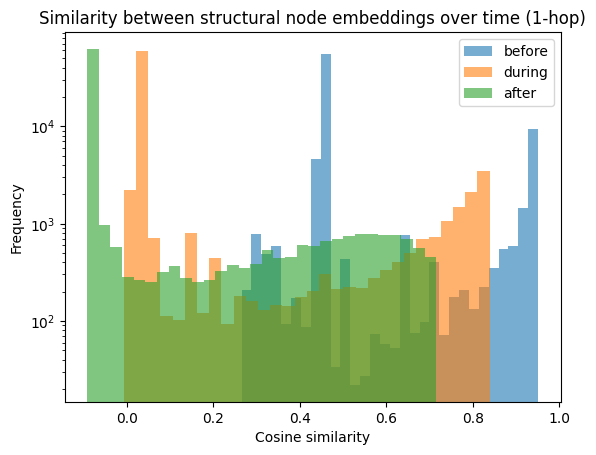

In [13]:
from torch.nn import CosineSimilarity

cosine = CosineSimilarity(dim=1, eps=1e-6)

label = {
    1: 'before',
    2: 'during',
    3: 'after'
}

for i in range(1,4):
    ti = node_states[i][hop]
    sim = cosine(node_states[0][hop], ti)
    plt.hist(sim.detach().numpy(), label=f'{label[i]}', bins=30, alpha=0.6)
    plt.legend(loc='upper right')
    plt.yscale('log')
    plt.xlabel('Cosine similarity')
    plt.ylabel('Frequency')
    plt.title(f'Similarity between structural node embeddings over time ({hop+1}-hop)')
#plt.savefig(f'results/cosine_{feature}_{hop+1}.pdf', bbox_inches='tight')
plt.show()

### NMI on User Clustering

In [14]:
from sklearn.cluster import Birch
from sklearn.metrics import silhouette_score

n_clusters = 8 #max clusters: 8 1-hop, 7 2-hop


labels = []
for i in range(0,4):
    X = node_states[i][hop].detach().numpy()
    brc = Birch(n_clusters=n_clusters) #default parameters
    brc.fit(X)
    y=brc.predict(X)
    #print(silhouette_score(X,y))
    labels.append(y)

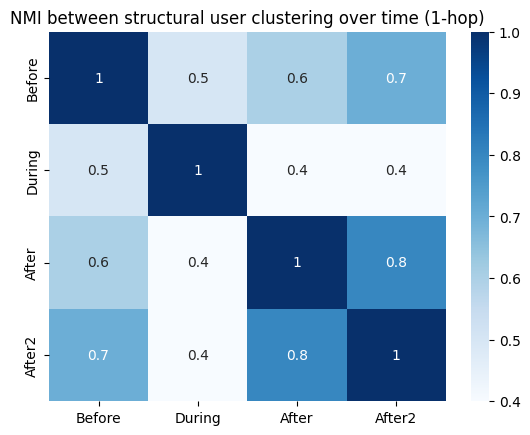

In [15]:
import seaborn as sns
from sklearn.metrics.cluster import normalized_mutual_info_score

group = ['Before','During','After','After2']

nmis = [[round(normalized_mutual_info_score(labels[j], labels[i]),1) for i in range(0,4)] for j in range(0,4)]

sns.heatmap(nmis, cmap='Blues', annot=True, xticklabels=group, yticklabels=group)
plt.title(f'NMI between structural user clustering over time ({hop+1}-hop)')
#plt.savefig(f'results/NMI_{feature}_{hop+1}.pdf', bbox_inches='tight')
plt.show()

### Polarization?

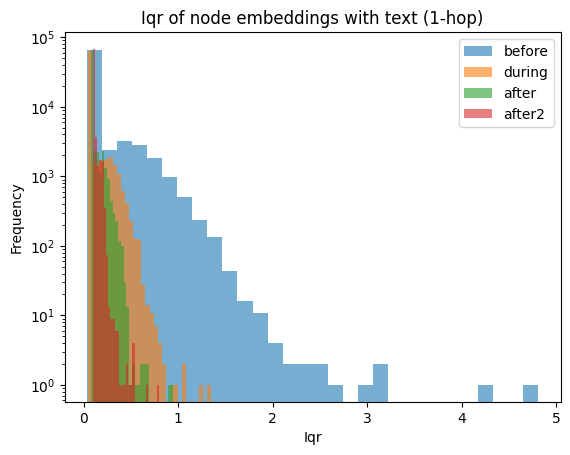

In [16]:
from scipy.stats import iqr

label = {
    0: 'before',
    1: 'during',
    2: 'after',
    3: 'after2'
    
}

for i in range(0,4):
    ti = node_states[i][hop].detach().numpy()
    g = iqr(ti,axis=1)
    plt.hist(g, label=f'{label[i]}', bins=30, alpha=0.6)
    plt.legend(loc='upper right')
    plt.yscale('log')
    plt.xlabel('Iqr')
    plt.ylabel('Frequency')
    plt.title(f'Iqr of node embeddings with text ({hop+1}-hop)')
    
#plt.savefig(f'results/iqr_{feature}_{hop+1}.pdf', bbox_inches='tight')
plt.show()